In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.feature_extraction.text import CountVectorizer
from FeatureEngine.FeatureMethods import FeatureEngine, fuzzy_merge, Supervised_Analyzer, GenerateCramersVMatrix
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#from nltk.tag import StanfordNERTagger
#from nltk.tokenize import word_tokenize



print(Path.cwd())

pathBase = str(Path.cwd())
cv = CountVectorizer()

#Classification field is for the multi-way classification training

#df DataFrame is used for training. Using old less accurate data, and new more accurate data for validation
#df_train_old = pd.read_csv(pathBase + "\Datasets\TeraSample_Supervised_MM.csv") 
df_train_new =  pd.read_csv(pathBase + "\Datasets\HCP_Train.csv")

#df_train_old = df_train_old.loc[df_train_old.Classification.isnull() == False]

#df = pd.concat([df_train_old, df_train_new])
df = df_train_new

#dfValidate is used for unlabeled data
dfValidate = pd.read_csv(pathBase + "\Datasets\HCP Classifications_1000_Test.csv")
dfValidate['HCPClass'] = '' #initialized a blank target feature, note: use Classification for multi-class and HCPClass for binary
#df_test = pd.read_csv(pathBase + "\Datasets\HCP_TestNew.csv")
#dfOP = pd.read_csv(pathBase + "\Datasets\OpenPmntsVendors.csv")


with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.astype('object').describe().transpose())
    print(dfValidate.astype('object').describe().transpose())

c:\Users\dylan.levine\Development\HCP Classification\HCP-Classification
                                  count   unique  \
COMP_CODE                        480722        1   
AC_DOC_LN                        480722      201   
AC_DOC_NR                        480722   181001   
AC_DOC_TYP                       480722        2   
AC_DOC_TYP_T                     480722        2   
ACCNT_GRPV                       480722        4   
AP Clearing Date                 480722      656   
AP Clearing Doc No.              480722    81069   
BI_ACCNT_TGRPV                   480722        4   
BIC_ZHIERLV3                     480722       25   
HCPClass                         480722        2   
COMP_CODE_T                      480722        1   
APPENDTEXT                       480722   122022   
Compliance_Bucket                 13471       14   
DOC_CURRCY                       480722       29   
DOC_DATE                         480722     1473   
Expense Division                 480722     

In [2]:
#Define DateEncode as basic features such as day of week, month int, and year int.
#Define groupencode as placing into buckets
#Define mapencode as mapping values to a higher-level grouping

#Define relavent fields to model and their associated data types and feature engineering methods

colDict = {
    "COMP_CODE": {"Type":"Categorical", "Method":"1hot"}, #In
    #"REF_KEY1":{"Type":"Categorical", "Method":"1hot"},
    "AC_DOC_NR": {"Type":"ID", "Method":"N/A"},
    "PSTNG_DATE":{"Type":"Date", "Method":"DateEncode"},
    #"CREATEDON":{"Type":"Date", "Method":"DateEncode"},
    "DOC_DATE":{"Type":"Date", "Method":"DateEncode"},
    "PROFIT_CTR":{"Type":"Categorical", "Method":"1hot"},
    "AC_DOC_TYP":{"Type":"Categorical", "Method":"1hot"},
    "POST_KEY":{"Type":"Categorical", "Method":"1hot"},
    "V.VENDOR":{"Type":"Categorical", "Method":"MapEncode"},#Was creditor
    "V.NAME":{"Type":"Text", "Method":"Tokenize"}, #Was name
    "GL_ACCOUNT":{"Type":"Categorical", "Method":"1hot"},
    #"CUSTOMER":{"Type":"Categorical", "Method":"MapEncode"}, no longer included
    "POSTXT":{"Type":"Text", "Method":"Tokenize"},
    #"BIC_ZUSERNAM":{"Type":"Categorical", "Method":"MapEncode"}, no longer included
    "ZBKTXT":{"Type":"Text", "Method":"Tokenize"},
    "ZTCODE":{"TYpe":"Categorical", "Method":"1hot"},
    "DEB_CRE_USD":{"Type":"Numerical", "Method":"GroupEncode"},
    "V.BIC_ZTERMPAY":{"Type":"Categorical", "Method":"1hot"},
    "MATL_GROUP":{"Type":"Categorical", "Method":"1hot"},
    "ACCNT_GRPV":{"Type":"Categorical", "Method":"1hot"},
    "HCPClass":{"Type":"Categorical", "Method":"LabelEncode"}, #Target
    "Compliance_Bucket":{"Type":"Categorical", "Method":"1hot"},
    "V.BI_ACCNT_TGRPV":{"Type":"Categorical", "Method":"1hot"} #Vendor type
}

oneHotFeatures = ["PROFIT_CTR","AC_DOC_TYP","POST_KEY","GL_ACCOUNT","ZTCODE", "MATL_GROUP", "ACCNT_GRPV","V.BI_ACCNT_TGRPV", "V.BIC_ZTERMPAY"]


#Set pandas datatypes for each field
df['COMP_CODE'] = df['COMP_CODE'].astype('object')
#df['REF_KEY1'] = df['REF_KEY1'].astype('object')
df['AC_DOC_NR'] = df['AC_DOC_NR'].astype('str')
df['PSTNG_DATE'] = pd.to_datetime(df['PSTNG_DATE'], format="%Y%m%d")
#df['CREATEDON'] = pd.to_datetime(df['CREATEDON'].astype('object'), format="%Y%m%d")
df['DOC_DATE'] = pd.to_datetime(df['DOC_DATE'], format="%Y%m%d")
df['PROFIT_CTR'] = df['PROFIT_CTR'].astype('str')
df['AC_DOC_TYP'] = df['AC_DOC_TYP'].astype('object')
df['POST_KEY'] = df['POST_KEY'].astype('str')
#df_test['POST_KEY'] = df_test['POST_KEY'].astype('int')
df['V.VENDOR'] = df['V.VENDOR'].astype('object') #was CREDITOR
df['V.NAME'] = df['V.NAME'].astype('object') #Was #name
df['GL_ACCOUNT'] = df['GL_ACCOUNT'].astype('int')
#df_test['GL_ACCOUNT'] = df_test['GL_ACCOUNT'].astype('object')
#df['CUSTOMER'] = df['CUSTOMER'].astype('object') no longer included
df['POSTXT'] = df['POSTXT'].astype('object')
#df['BIC_ZUSERNAM'] = df['BIC_ZUSERNAM'].astype('object') no longer included, but may be useful to bring back
df['ZBKTXT'] = df['ZBKTXT'].astype('object')
df['ZTCODE'] = df['ZTCODE'].astype('str')
df['DEB_CRE_USD'] = pd.to_numeric(df['DEB_CRE_USD'])
df['V.BIC_ZTERMPAY'] = df['V.BIC_ZTERMPAY'].astype('str') #no longer included, but may be useful to bring back
df['MATL_GROUP'] = df['MATL_GROUP'].astype('str')
df['ACCNT_GRPV'] = df['ACCNT_GRPV'].astype('str')
df['HCPClass'] = df['HCPClass'].astype('object') #Classification for multiclass and HCPClass for binary
df['Compliance_Bucket'] = df['Compliance_Bucket'].astype("object")
df['V.BI_ACCNT_TGRPV'] = df['V.BI_ACCNT_TGRPV'].astype("str")




#Filter data for relavent rows
#df = df[ ((df.POST_KEY == '40') | (df.POST_KEY == '81')) & (df.GL_ACCOUNT >= 40000000)]

df['GL_ACCOUNT'] = df['GL_ACCOUNT'].astype('str')
#Filter data for relavent rows
#df_test = df_test[ ((df_test.POST_KEY == 40) | (df_test.POST_KEY == 81)) & (df_test.GL_ACCOUNT >= 40000000)]

#Get list of relavent fields
#colSelect = list(colDict.keys())
colSelectTrain = ['COMP_CODE', 'AC_DOC_NR','DOC_DATE', 'PSTNG_DATE', 'PROFIT_CTR', 'AC_DOC_TYP', 'POST_KEY', 'V.VENDOR', 'V.NAME', 'GL_ACCOUNT', 'POSTXT', 'ZBKTXT' ,'ZTCODE', 'V.BIC_ZTERMPAY', 'MATL_GROUP', 'ACCNT_GRPV', 'V.BI_ACCNT_TGRPV', 'HCPClass', 'Compliance_Bucket', 'DEB_CRE_USD']
#Use 'Classification' field for multi-class and use HCPClass for binary classification
#REMOVED DOC_DATE feature

#df[colSelect]
df = df[colSelectTrain]

#df_test[colSelect]


df
#df

,COMP_CODE,AC_DOC_NR,DOC_DATE,PSTNG_DATE,PROFIT_CTR,AC_DOC_TYP,POST_KEY,V.VENDOR,V.NAME,GL_ACCOUNT,POSTXT,ZBKTXT,ZTCODE,V.BIC_ZTERMPAY,MATL_GROUP,ACCNT_GRPV,V.BI_ACCNT_TGRPV,HCPClass,Compliance_Bucket,DEB_CRE_USD
0,1003,1900002312,2019-01-10,2019-01-10,10032,KR,50,10192982,ASL USA CORP,62000106,PROMO ITEMS UMBRELLAS OCT18,7000224278,nan,23,nan,Z001,Vendor (Legal Entity),Non-Compliance,Professional Services Agreements,-470.82
1,1003,1900076313,2019-11-04,2019-11-15,13414,KR,50,30003244,MEETINGS & INCENTIVES,62000106,AL31A M&IW 19-1132F AL31A-031,AL31A M&IW 19-1132F AL31A,nan,23,nan,Z003,Invoicing Party,Non-Compliance,Professional Services Agreements,-1926.69
2,1003,1900070336,2019-08-23,2019-10-22,10021,KR,50,30001229,BSA -NORTHEAST ILLINOIS COUNCIL,64200101,NORTHEAST ILLINOIS COUNCI,NaN,FB08,17,nan,Z003,Invoicing Party,Non-Compliance,Charitable Contributions,-15000.00
3,1003,1900033700,2019-02-14,2019-05-20,12939,KR,50,30082389,ENVIRONMENTAL SUPPORT SOLUTIONS,62000106,NaN,NaN,FB65,17,nan,Z003,Invoicing Party,Non-Compliance,Professional Services Agreements,-514.00
4,1003,1900033699,2019-04-17,2019-05-20,12939,KR,50,30082389,ENVIRONMENTAL SUPPORT SOLUTIONS,62000106,NaN,NaN,FB65,17,nan,Z003,Invoicing Party,Non-Compliance,Professional Services Agreements,-514.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480717,1003,5100021329,2018-06-20,2019-01-31,10021,RE,40,30094250,GORDON FOOD SERVICE,24120103,MR8M,NaN,MR8M,23,nan,Z003,Invoicing Party,Non-Compliance,NaN,0.53
480718,1003,5100021329,2018-06-20,2019-01-31,10021,RE,40,30094250,GORDON FOOD SERVICE,24120103,MR8M,NaN,MR8M,23,nan,Z003,Invoicing Party,Non-Compliance,NaN,0.21
480719,1003,5100014945,2019-01-16,2019-01-24,10021,RE,40,30002858,RODEM INC,24120103,MR8M,NaN,MR8M,23,nan,Z003,Invoicing Party,Non-Compliance,NaN,11.32
480720,1003,5100014945,2019-01-16,2019-01-24,10021,RE,40,30002858,RODEM INC,24120103,MR8M,NaN,MR8M,23,nan,Z003,Invoicing Party,Non-Compliance,NaN,52.10


In [3]:
#Define DateEncode as basic features such as day of week, month int, and year int.
#Define groupencode as placing into buckets
#Define mapencode as mapping values to a higher-level grouping

#Define relavent fields to model and their associated data types and feature engineering methods

colDict = {
    "COMP_CODE": {"Type":"Categorical", "Method":"1hot"}, #In
    #"REF_KEY1":{"Type":"Categorical", "Method":"1hot"},
    "AC_DOC_NR": {"Type":"ID", "Method":"N/A"},
    "PSTNG_DATE":{"Type":"Date", "Method":"DateEncode"},
    #"CREATEDON":{"Type":"Date", "Method":"DateEncode"},
    "DOC_DATE":{"Type":"Date", "Method":"DateEncode"},
    "PROFIT_CTR":{"Type":"Categorical", "Method":"1hot"},
    "AC_DOC_TYP":{"Type":"Categorical", "Method":"1hot"},
    "POST_KEY":{"Type":"Categorical", "Method":"1hot"},
    "V.VENDOR":{"Type":"Categorical", "Method":"MapEncode"},#Was creditor
    "V.NAME":{"Type":"Text", "Method":"Tokenize"}, #Was name
    "GL_ACCOUNT":{"Type":"Categorical", "Method":"1hot"},
    #"CUSTOMER":{"Type":"Categorical", "Method":"MapEncode"}, no longer included
    "POSTXT":{"Type":"Text", "Method":"Tokenize"},
    #"BIC_ZUSERNAM":{"Type":"Categorical", "Method":"MapEncode"}, no longer included
    "ZBKTXT":{"Type":"Text", "Method":"Tokenize"},
    "ZTCODE":{"TYpe":"Categorical", "Method":"1hot"},
    "DEB_CRE_USD":{"Type":"Numerical", "Method":"GroupEncode"},
    "V.BIC_ZTERMPAY":{"Type":"Categorical", "Method":"1hot"},
    "MATL_GROUP":{"Type":"Categorical", "Method":"1hot"},
    "ACCNT_GRPV":{"Type":"Categorical", "Method":"1hot"},
    "HCPClass":{"Type":"Categorical", "Method":"LabelEncode"}, #Target
    "Compliance_Bucket":{"Type":"Categorical", "Method":"1hot"},
    "V.BI_ACCNT_TGRPV":{"Type":"Categorical", "Method":"1hot"} #Vendor type
}

oneHotFeatures = ["PROFIT_CTR","AC_DOC_TYP","POST_KEY","GL_ACCOUNT","ZTCODE", "MATL_GROUP","V.BI_ACCNT_TGRPV", "V.BIC_ZTERMPAY"]


#Set pandas datatypes for each field
dfValidate['COMP_CODE'] = dfValidate['COMP_CODE'].astype('object')
#dfValidateValidate['REF_KEY1'] = dfValidateValidate['REF_KEY1'].astype('object')
dfValidate['AC_DOC_NR'] = dfValidate['AC_DOC_NR'].astype('str')
dfValidate['PSTNG_DATE'] = pd.to_datetime(dfValidate['PSTNG_DATE'], format="%Y%m%d")
#dfValidateValidate['CREATEDON'] = pd.to_datetime(dfValidateValidate['CREATEDON'].astype('object'), format="%Y%m%d")
dfValidate['DOC_DATE'] = pd.to_datetime(dfValidate['DOC_DATE'], format="%Y%m%d")
dfValidate['PROFIT_CTR'] = dfValidate['PROFIT_CTR'].astype('str')
dfValidate['AC_DOC_TYP'] = dfValidate['AC_DOC_TYP'].astype('object')
dfValidate['POST_KEY'] = dfValidate['POST_KEY'].astype('str')
#dfValidateValidate_test['POST_KEY'] = dfValidateValidate_test['POST_KEY'].astype('int')
dfValidate['V.VENDOR'] = dfValidate['V.VENDOR'].astype('object') #was CREDITOR
dfValidate['V.NAME'] = dfValidate['V.NAME'].astype('object') #Was #name
dfValidate['GL_ACCOUNT'] = dfValidate['GL_ACCOUNT'].astype('int')
#dfValidate_test['GL_ACCOUNT'] = dfValidate_test['GL_ACCOUNT'].astype('object')
#dfValidate['CUSTOMER'] = dfValidate['CUSTOMER'].astype('object') no longer included
dfValidate['POSTXT'] = dfValidate['POSTXT'].astype('object')
#dfValidate['BIC_ZUSERNAM'] = dfValidate['BIC_ZUSERNAM'].astype('object') no longer included, but may be useful to bring back
dfValidate['ZBKTXT'] = dfValidate['ZBKTXT'].astype('object')
dfValidate['ZTCODE'] = dfValidate['ZTCODE'].astype('str')
dfValidate['DEB_CRE_USD'] = pd.to_numeric(dfValidate['DEB_CRE_USD'])
dfValidate['V.BIC_ZTERMPAY'] = dfValidate['V.BIC_ZTERMPAY'].astype('str') #no longer included, but may be useful to bring back
dfValidate['MATL_GROUP'] = dfValidate['MATL_GROUP'].astype('str')
dfValidate['ACCNT_GRPV'] = dfValidate['ACCNT_GRPV'].astype('str')
dfValidate['HCPClass'] = dfValidate['HCPClass'].astype('object')
dfValidate['Classification'] = dfValidate['Classification'].astype('object')
dfValidate['Compliance_Bucket'] = dfValidate['Compliance_Bucket'].astype("object")
dfValidate['V.BI_ACCNT_TGRPV'] = dfValidate['V.BI_ACCNT_TGRPV'].astype("str")




#Filter data for relavent rows
#dfValidate = dfValidate[ ((dfValidate.POST_KEY == '40') | (dfValidate.POST_KEY == '81')) & (dfValidate.GL_ACCOUNT >= 40000000)]

dfValidate['GL_ACCOUNT'] = dfValidate['GL_ACCOUNT'].astype('str')
#Filter data for relavent rows
#dfValidate_test = dfValidate_test[ ((dfValidate_test.POST_KEY == 40) | (dfValidate_test.POST_KEY == 81)) & (dfValidate_test.GL_ACCOUNT >= 40000000)]

#Get list of relavent fields
#colSelect = list(colDict.keys())

colSelectTest = ['COMP_CODE', 'AC_DOC_NR','DOC_DATE', 'PSTNG_DATE', 'PROFIT_CTR', 'AC_DOC_TYP', 'POST_KEY', 'V.VENDOR', 'V.NAME', 'GL_ACCOUNT', 'POSTXT', 'ZBKTXT' ,'ZTCODE', 'V.BIC_ZTERMPAY', 'MATL_GROUP', 'ACCNT_GRPV', 'V.BI_ACCNT_TGRPV', 'HCPClass', 'Compliance_Bucket', 'DEB_CRE_USD', 'Classification']
#dfValidate[colSelect]
dfValidate = dfValidate[colSelectTest]

#dfValidate_test[colSelect]


dfValidate

,COMP_CODE,AC_DOC_NR,DOC_DATE,PSTNG_DATE,PROFIT_CTR,AC_DOC_TYP,POST_KEY,V.VENDOR,V.NAME,GL_ACCOUNT,...,ZBKTXT,ZTCODE,V.BIC_ZTERMPAY,MATL_GROUP,ACCNT_GRPV,V.BI_ACCNT_TGRPV,HCPClass,Compliance_Bucket,DEB_CRE_USD,Classification
0,1000,1900100212,2019-07-18,2019-07-18,12935,KR,40,10015518,CALTOP COOPERATIVE INC,64900101,...,LEAN 51728477,nan,23,nan,Z001,Vendor (Legal Entity),,NaN,70.53,Non-HCP
1,1000,1900102019,2019-07-27,2019-07-27,12935,KR,40,10009875,AVERITT EXPRESS INC,64900101,...,LEAN 51828002,nan,23,nan,Z001,Vendor (Legal Entity),,NaN,184.24,Non-HCP
2,1000,1900089093,2019-06-29,2019-07-02,12935,KR,40,10002840,DAYTON FREIGHT LINES,64900101,...,LEAN 51129303,nan,23,nan,Z001,Vendor (Legal Entity),,NaN,268.31,Non-HCP
3,1000,1900089971,2019-06-20,2019-07-03,12935,KR,40,10004478,STAR DISTRIBUTION SYSTEMS,64900101,...,LEAN 51056849,nan,23,nan,Z001,Vendor (Legal Entity),,NaN,100.51,Non-HCP
4,1000,1900094145,2019-07-02,2019-07-02,12935,KR,40,10015518,CALTOP COOPERATIVE INC,64900101,...,LEAN 51391217,nan,23,nan,Z001,Vendor (Legal Entity),,NaN,70.53,Non-HCP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443287,1000,5100018908,2020-07-30,2020-07-31,10021,RE,50,10003556,"EXPERIS US, INC.",24120103,...,NaN,MR1M,23,nan,Z001,Vendor (Legal Entity),,NaN,-8.04,Non-HCP
443288,1000,5100017033,2020-07-09,2020-07-10,10021,RE,50,10003556,"EXPERIS US, INC.",24120103,...,NaN,MR1M,23,nan,Z001,Vendor (Legal Entity),,NaN,-1.21,Non-HCP
443289,1000,5100017577,2020-07-16,2020-07-17,10021,RE,50,10003556,"EXPERIS US, INC.",24120103,...,NaN,MR1M,23,nan,Z001,Vendor (Legal Entity),,NaN,-1.58,Non-HCP
443290,1000,5100018889,2020-07-30,2020-07-31,10021,RE,50,10030946,HIREGENICS INC,24120103,...,NaN,MR1M,23,nan,Z001,Vendor (Legal Entity),,NaN,-4.75,Non-HCP


In [4]:
#Clean and transform data
#To consider fuzzy matching vendor names against the complete listing of vendor names on https://openpaymentsdata.cms.gov/dataset/General-Payment-Data-Detailed-Dataset-2019-Reporti/svgu-ws3x

#Replaces all ? with numpy nan val
df = df[colSelectTrain].replace("?", np.nan)
dfValidate = dfValidate[colSelectTest].replace("?", np.nan)

#For encoding purposes replaces nans with a related text identifier
#df['REF_KEY1'] = df['REF_KEY1'].replace(np.nan, "nan_REF_KEY1")
#df['CUSTOMER'] = df['CUSTOMER'].replace(np.nan, "nan_CUSTOMER") #Probablly don't need customer field
df['MATL_GROUP'] = df['MATL_GROUP'].replace(np.nan, "nan_MATL_GROUP")
df['ACCNT_GRPV'] = df['ACCNT_GRPV'].replace(np.nan,"nan_ACCNT_GRPV") 
dfValidate['MATL_GROUP'] = dfValidate['MATL_GROUP'].replace(np.nan, "nan_MATL_GROUP")
dfValidate['ACCNT_GRPV'] = dfValidate['ACCNT_GRPV'].replace(np.nan,"nan_ACCNT_GRPV") 


df['Compliance_Bucket'] = df['Compliance_Bucket'].replace(np.nan,"nan_Compliance_Bucket") 
dfValidate['Compliance_Bucket'] = dfValidate['Compliance_Bucket'].replace(np.nan,"nan_Compliance_Bucket") 

#Maps each record as either a system or user generated record. Note dialog and not dialog (non-human) is how SAP identifies it
#df.loc[df.BIC_ZUSERNAM != "AUTOSYS", 'BIC_ZUSERNAM_BINARY'] = "USER"
#df.loc[df.BIC_ZUSERNAM == "AUTOSYS", 'BIC_ZUSERNAM_BINARY'] = "SYSTEM" #USR02 table will help identify whether or not an account is diaglog

#V.CREATEDBY

df.loc[df.DOC_DATE == np.nan, 'DOC_DATE'] = df['PSTNG_DATE'] # if the doc date is blank then that could be a relvaent feature in and of itself. Technically should always have a doc date.
dfValidate.loc[dfValidate.DOC_DATE == np.nan, 'DOC_DATE'] = dfValidate['PSTNG_DATE'] # if the doc date is blank then that could be a relvaent feature in and of itself. Technically should always have a doc date.

#Feature to check if doc_date == psting_date. Might indicate some type of manual entry that would be less likely to be HCP?
df['DateEqual'] = df['DOC_DATE'] == df['PSTNG_DATE'] 
dfValidate['DateEqual'] = dfValidate['DOC_DATE'] == dfValidate['PSTNG_DATE']
df['DateDiff'] = df['DOC_DATE'] - df['PSTNG_DATE'] 
dfValidate['DateDiff'] = dfValidate['DOC_DATE'] - dfValidate['PSTNG_DATE']

df['DateDiff'] = df['DateDiff'].dt.days
dfValidate['DateDiff'] = dfValidate['DateDiff'].dt.days

#Counts # of historical transacations a vendor has had in provided dataset
vendorCount = df[['V.VENDOR', 'AC_DOC_NR']].groupby(by=['V.VENDOR']).count().rename(columns={'AC_DOC_NR':'TransCount'})
df = df.merge(vendorCount, how='left', right_on='V.VENDOR',left_on='V.VENDOR')

vendorCount = dfValidate[['V.VENDOR', 'AC_DOC_NR']].groupby(by=['V.VENDOR']).count().rename(columns={'AC_DOC_NR':'TransCount'})
dfValidate = dfValidate.merge(vendorCount, how='left', right_on='V.VENDOR',left_on='V.VENDOR')



#Calculates mean of historical transacations for each vendor and merges back as a feature
vendorMean = df[['V.VENDOR', 'DEB_CRE_USD']].groupby(by=['V.VENDOR']).mean().rename(columns={'DEB_CRE_USD':'TransMean'})
df = df.merge(vendorMean, how='left', right_on='V.VENDOR',left_on='V.VENDOR')
vendorMean = dfValidate[['V.VENDOR', 'DEB_CRE_USD']].groupby(by=['V.VENDOR']).mean().rename(columns={'DEB_CRE_USD':'TransMean'})
dfValidate = dfValidate.merge(vendorMean, how='left', right_on='V.VENDOR',left_on='V.VENDOR')

#Converts ZBTXT and POSTXT to lower case
df['ZBKTXT'] = df['ZBKTXT'].str.lower()
dfValidate['ZBKTXT'] = dfValidate['ZBKTXT'].str.lower()
df['POSTXT'] = df['POSTXT'].str.lower()
dfValidate['POSTXT'] = dfValidate['POSTXT'].str.lower()

#Need to map vendors to whether or not the vendor has had an HCP transacation before
#Need to map customers to a group type
#Need to map G/L accounts to whether or not it is a common HCP G/L

#Removes all integers and Convert all strings to lowercase, and then capitalizes first letter of each word in string. Capitalization is utilized for NER using a pre-trained NER spacy model.

df['V.NAME'] = df['V.NAME'].str.replace('\d+', '')
df['V.NAME'] = df['V.NAME'].str.lower()
df['V.NAME'] = df['V.NAME'].str.title()
dfValidate['V.NAME'] = dfValidate['V.NAME'].str.replace('\d+', '')
dfValidate['V.NAME'] = dfValidate['V.NAME'].str.lower()
dfValidate['V.NAME'] = dfValidate['V.NAME'].str.title()


#Consolidated feature of various text fields separated by space for future vectorization features.
df['textappend'] = df['V.NAME'].astype(str) +" "+ df['POSTXT'].astype(str) +" "+ df["ZBKTXT"].astype(str)
dfValidate['textappend'] = dfValidate['V.NAME'].astype(str) +" "+ dfValidate['POSTXT'].astype(str) +" "+ dfValidate["ZBKTXT"].astype(str)



#Can use this if we want to search for states
stateReg = 'AL|Alabama|AK|Alaska|AZ|Arizona|AR|Arkansas|CA|California|CO|Colorado|CT|Connecticut|DE|Delaware|FL|Florida|GA|Georgia|HI|Hawaii|ID|Idaho|IL|Illinois|IN|Indiana|IA|Iowa|KS|Kansas|KY|Kentucky|LA|Louisiana|ME|Maine|MD|Maryland|MA|Massachusetts|MI|Michigan|MN|Minnesota|MS|Mississippi|MO|Missouri|MT|Montana|NE|Nebraska|NV|Nevada|NH|New Hampshire|NJ|New Jersey|NM|New Mexico|NY|New York|NC|North Carolina|ND|North Dakota|OH|Ohio|OK|Oklahoma|OR|Oregon|PA|Pennsylvania|RI|Rhode Island|SC|South Carolina|SD|South Dakota|TN|Tennessee|TX|Texas|UT|Utah|VT|Vermont|VA|Virginia|WA|Washington|WV|West Virginia|WI|Wisconsin|WY|Wyoming'
stateRegFull = 'Alabama|Alaska|Arizona|Arkansas|California|Colorado|Connecticut|Delaware|Florida|Georgia|Hawaii|Idaho|Illinois|Indiana|Iowa|Kansas|Kentucky|Louisiana|Maine|Maryland|Massachusetts|Michigan|Minnesota|Mississippi|Missouri|Montana|Nebraska|Nevada|New Hampshire|New Jersey|New Mexico|New York|North Carolina|North Dakota|Ohio|Oklahoma|Oregon|Pennsylvania|Rhode Island|South Carolina|South Dakota|Tennessee|Texas|Utah|Vermont|Virginia|Washington|West Virginia|Wisconsin|Wyoming'

#Regex search of defined compliance "trigger" words
#Note certain employee vendor expenses will denote "HCP" explicitly in the postxt 
textFields = ['V.NAME', 'POSTXT', 'ZBKTXT']

for field in textFields:
    df['TriggerWord_HCP'+ field] = df[field].str.contains('^.*(\\bdr |HCP|MD|dr\.).*$', case=False) #To make sure we rework this so that it excludes those records that are explicitly non-hcp
    dfValidate['TriggerWord_HCP'+ field] = dfValidate[field].str.contains('^.*(\\bdr |HCP|MD|dr\.).*$', case=False)

    df['TriggerWord_HCO'+ field] = df[field].str.contains('surgical|hosp|medic|health|poly|farma|pharma|dent|clinic|nutri|pedia|drug|lab|neuro|physic|practic|University|college|podia|children|pediatric|respiratory', case=False)
    dfValidate['TriggerWord_HCO'+ field] = dfValidate[field].str.contains('surgical|hosp|medic|health|poly|farma|pharma|dent|clinic|nutri|pedia|drug|lab|neuro|physic|practic|University|college|podia|children|pediatric|respiratory', case=False)

    df['TriggerWord_GOVT'+ field] = df[field].str.contains('dept of|department of|police|muncip|army|air force|navy|military', case=False)
    dfValidate['TriggerWord_GOVT'+ field] = dfValidate[field].str.contains('dept of|department of|police|muncip|army|air force|navy|military', case=False)

    #df['Business'] to include a business trigerword feature, look at Michael's formula for reference
    #df['Legal'] to include a legal triggerword feature, look at Michael's formula for reference
    #Org vs. Person to bring in the field that Michael has already created. 

    df['TriggerWord_HCP'+ field] = df['TriggerWord_HCP'+ field].replace(True, 1)
    df['TriggerWord_HCP'+ field] = df['TriggerWord_HCP'+ field].replace(False, 0)
    dfValidate['TriggerWord_HCP'+ field] = dfValidate['TriggerWord_HCP'+ field].replace(True, 1)
    dfValidate['TriggerWord_HCP'+ field] = dfValidate['TriggerWord_HCP'+ field].replace(False, 0)
    df['TriggerWord_HCO'+ field] = df['TriggerWord_HCO'+ field].replace(True, 1)
    df['TriggerWord_HCO'+ field] = df['TriggerWord_HCO'+ field].replace(False, 0)
    dfValidate['TriggerWord_HCO'+ field] = dfValidate['TriggerWord_HCO'+ field].replace(True, 1)
    dfValidate['TriggerWord_HCO'+ field] = dfValidate['TriggerWord_HCO'+ field].replace(False, 0)
    df['TriggerWord_GOVT'+ field] = df['TriggerWord_GOVT'+ field].replace(True, 1)
    df['TriggerWord_GOVT'+ field] = df['TriggerWord_GOVT'+ field].replace(False, 0)
    dfValidate['TriggerWord_GOVT'+ field] = dfValidate['TriggerWord_GOVT'+ field].replace(True, 1)
    dfValidate['TriggerWord_GOVT'+ field] = dfValidate['TriggerWord_GOVT'+ field].replace(False, 0)

#df['HCPTransacation'] = np.random.randint(2, size=df.shape[0])


#This function is not a quick one. There are more effecient ways that we'll need to look into.
#df = df.apply(getEntLabel, fieldString='V.NAME', axis=1)





In [5]:
featureDict1 = {'Compliance_Bucket':'1hot', 'PROFIT_CTR':'1hot','AC_DOC_TYP':'1hot','POST_KEY':'1hot','GL_ACCOUNT':'1hot','V.BIC_ZTERMPAY':'1hot','MATL_GROUP':'1hot','V.BI_ACCNT_TGRPV':'1hot','HCPClass':'Target','DateEqual':'Passthrough_Transform','TransMean':'Passthrough_Transform','TransCount':'Passthrough_Transform','TriggerWord_HCPV.NAME':'Passthrough_Transform','TriggerWord_HCPPOSTXT':'Passthrough_Transform','TriggerWord_HCPZBKTXT':'Passthrough_Transform','TriggerWord_HCOV.NAME':'Passthrough_Transform','TriggerWord_HCOPOSTXT':'Passthrough_Transform','TriggerWord_HCOZBKTXT':'Passthrough_Transform','TriggerWord_GOVTV.NAME':'Passthrough_Transform','TriggerWord_GOVTPOSTXT':'Passthrough_Transform','TriggerWord_GOVTZBKTXT':'Passthrough_Transform', 'DateDiff':'Passthrough_Transform'} #All, note to add the org vs. person field into here, but need to bring into the dataframes first

featureDict2 = {'Compliance_Bucket':'1hot', 'PROFIT_CTR':'1hot','AC_DOC_TYP':'1hot','POST_KEY':'1hot','GL_ACCOUNT':'1hot','V.BIC_ZTERMPAY':'1hot','MATL_GROUP':'1hot','V.BI_ACCNT_TGRPV':'1hot','HCPClass':'Target','TransMean':'Passthrough_Transform','TransCount':'Passthrough_Transform','TriggerWord_HCPV.NAME':'Passthrough_Transform','TriggerWord_HCPPOSTXT':'Passthrough_Transform','TriggerWord_HCPZBKTXT':'Passthrough_Transform','TriggerWord_HCOV.NAME':'Passthrough_Transform','TriggerWord_HCOPOSTXT':'Passthrough_Transform','TriggerWord_HCOZBKTXT':'Passthrough_Transform','TriggerWord_GOVTV.NAME':'Passthrough_Transform','TriggerWord_GOVTPOSTXT':'Passthrough_Transform','TriggerWord_GOVTZBKTXT':'Passthrough_Transform'} #Without DateEqual and DateDiff features
featureDict3 = {'Compliance_Bucket':'1hot', 'PROFIT_CTR':'1hot','AC_DOC_TYP':'1hot','POST_KEY':'1hot','GL_ACCOUNT':'1hot','V.BIC_ZTERMPAY':'1hot','MATL_GROUP':'1hot','V.BI_ACCNT_TGRPV':'1hot','HCPClass':'Target','TriggerWord_HCPV.NAME':'Passthrough_Transform','TriggerWord_HCPPOSTXT':'Passthrough_Transform','TriggerWord_HCPZBKTXT':'Passthrough_Transform','TriggerWord_HCOV.NAME':'Passthrough_Transform','TriggerWord_HCOPOSTXT':'Passthrough_Transform','TriggerWord_HCOZBKTXT':'Passthrough_Transform','TriggerWord_GOVTV.NAME':'Passthrough_Transform','TriggerWord_GOVTPOSTXT':'Passthrough_Transform','TriggerWord_GOVTZBKTXT':'Passthrough_Transform'} #Without DateEqual, DateDiff, Transmean, and Transcount

#To consider dropping out either Compliance_Bucket vs. GL_Account, or test both, to drop COMP_CODE
featureDict4 = {'Compliance_Bucket':'1hot', 'PROFIT_CTR':'1hot','AC_DOC_TYP':'1hot','GL_ACCOUNT':'1hot','V.BIC_ZTERMPAY':'1hot','HCPClass':'Target','TriggerWord_HCPV.NAME':'Passthrough_Transform','TriggerWord_HCPPOSTXT':'Passthrough_Transform','TriggerWord_HCPZBKTXT':'Passthrough_Transform','TriggerWord_HCOV.NAME':'Passthrough_Transform','TriggerWord_HCOPOSTXT':'Passthrough_Transform','TriggerWord_HCOZBKTXT':'Passthrough_Transform','TriggerWord_GOVTV.NAME':'Passthrough_Transform','TriggerWord_GOVTPOSTXT':'Passthrough_Transform','TriggerWord_GOVTZBKTXT':'Passthrough_Transform'} #Without DateEqual, DateDiff, Transmean, Transcount, ACCNT_GRPV, MATL_GROUP, and POST_KEY

#Use Classification for multiclass and HCPClass for Binary

featureCombinations = [featureDict1,featureDict2,featureDict3,featureDict4]

In [6]:
import pickle

featureString = featureDict4
featureName = 'featureDict4'

model = Supervised_Analyzer(df)
model = model.set_features(featureString).set_traintestsplit('HCPClass', 0.01).GetColumnTransformer().transformFeatures().FitXGBOOST()

with open(pathBase + "\Datasets\ModelOldNew_TextVector.pk1", 'wb') as f:
    pickle.dump(model, f)

model.models['XGB']['GSCV']

----Running grid search optimization----
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV 1/2] END booster=gbtree, colsample_bytree=0.9, early_stopping_rounds=50, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=500, nthread=-1, objective=binary:logistic, scale_pos_weight=0.009265287512326501, subsample=0.9, tree_method=hist, use_label_encoder=True, verbosity=0; total time=  57.9s
[CV 2/2] END booster=gbtree, colsample_bytree=0.9, early_stopping_rounds=50, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=500, nthread=-1, objective=binary:logistic, scale_pos_weight=0.009265287512326501, subsample=0.9, tree_method=hist, use_label_encoder=True, verbosity=0; total time= 1.0min
[CV 1/2] END booster=gbtree, colsample_bytree=0.9, early_stopping_rounds=50, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=1000, nthread=-1, objective=binary:logistic, scale_pos_weight=0.009265287512326501, subsample=0.9, tree_method=hist, use_label_enc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=50, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=12, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.009265287512326501, subsample=0.9,
              tree_method='hist', validate_parameters=1, verbosity=0)

In [7]:
#Cleanlab for noisy labels
import pickle

with open(pathBase + "\Datasets\ModelOldNew_TextVector.pk1", 'rb') as f:
    model = pickle.load(f)

modelValidate = Supervised_Analyzer(dfValidate)
modelValidate = modelValidate.set_features(featureString).set_traintestsplit('HCPClass', 0, modelTraining=False)
modelValidate.x_transformer = model.x_transformer
modelValidate = modelValidate.transformFeatures()

predicts = model.models['XGB']['GSCV'].predict(modelValidate.x_test)

df_test_x = modelValidate.df_test_x.reset_index(drop=True)
df_test_y = modelValidate.df_test_y.reset_index(drop=True)
df_predicts = pd.DataFrame({"Predicts":predicts})
dfConcat = pd.concat([df_predicts,dfValidate, df_test_y], axis=1)

#pd.DataFrame({"Predicts":predicts}) #0 to 3232 index
#model.df_test_y.to_frame().reset_index(drop=True) # 0 to 3232 index
#model.df_test_x.reset_index(drop=True) # 0 to 3232 index

dfConcat = dfConcat.loc[dfConcat.Classification.isnull() == False]
dfConcat.loc[dfConcat.Classification == 'Intercompany', 'Classification'] = 'Non-HCP'

dfConcat.loc[dfConcat.Classification != 'Non-HCP', 'Classification'] = 'Compliance'
dfConcat['Accuracy'] = dfConcat['Classification'] == dfConcat['Predicts']

dfModelResults = dfConcat.Predicts.value_counts().to_frame().transpose().rename(columns={'Non-Compliance':'Non-Compliance_XGBoost', 'Compliance':'Compliance_XGBoost'})
dfModelResults['ModelFeatures'] = str(featureString)
dfModelResults['ModelParams'] = str(model.models)
dfFormulaResults = dfConcat.Classification.value_counts().to_frame().transpose().rename(columns={'Non-HCP':'Non-Compliance_Formula', 'Compliance':'Compliance_Formula'})

dfModelSummary = pd.concat([dfModelResults.reset_index(drop=True), dfFormulaResults.reset_index(drop=True)], axis=1)

dfConcat.to_csv(r'C:\Users\dylan.levine\Downloads\HCPExports\HCPValidate_' + featureName + '.csv')

dfModelSummary.to_csv(r'C:\Users\dylan.levine\Downloads\HCPExports\ModelSummaries.csv', mode='a', header=False)


,Non-Compliance_XGBoost,Compliance_XGBoost,ModelFeatures,ModelParams,Non-Compliance_Formula,Compliance_Formula,Intercompany
0,438181,641,"{'COMP_CODE': '1hot', 'PROFIT_CTR': '1hot', 'A...","{'XGB': {'GSCV': XGBClassifier(base_score=0.5,...",437824,993,5


0         False
1         False
2         False
3         False
4         False
          ...  
443287    False
443288    False
443289    False
443290    False
443291    False
Name: Accuracy, Length: 438822, dtype: bool

# Break

In [17]:
from sklearn.feature_selection import RFECV
from xgboost.sklearn import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
featureList = ['COMP_CODE', 'AC_DOC_NR', 'PROFIT_CTR', 'AC_DOC_TYP', 'POST_KEY', 'GL_ACCOUNT', 'V.BIC_ZTERMPAY', 'MATL_GROUP', 'V.BI_ACCNT_TGRPV', 'HCPClass','DateEqual', 'TransMean', 'TransCount', 'TriggerWord_HCPV.NAME','TriggerWord_HCPPOSTXT','TriggerWord_HCPZBKTXT','TriggerWord_HCOV.NAME','TriggerWord_HCOPOSTXT','TriggerWord_HCOZBKTXT','TriggerWord_GOVTV.NAME','TriggerWord_GOVTPOSTXT','TriggerWord_GOVTZBKTXT']
#Removed DOC_DATE
#Use Classification for multiclass and HCPClass for Binary
model = Supervised_Analyzer(df)
model = model.set_features(featureList).set_traintestsplit('HCPClass', .5).GetColumnTransformer().transformFeatures()


#RFECV
estimator = XGBClassifier(booster='gbtree', nthread=-1, objective='binary:logistic', learning_rate='0.1', max_depth=5, min_child_weight=1, verbosity=0, subsample=0.9, colsample_bytree=0.9, n_estimators=100, use_label_encoder=True, early_stopping_Rounds=50, scale_pos_weight=100, tree_method='hist')
selector = RFECV(estimator, step=1, min_features_to_select=1, verbose=3,cv=2)

selector = selector.fit(model.x_train, model.y_train)

selector.support_


Fitting estimator with 304 features.
Fitting estimator with 303 features.
Fitting estimator with 302 features.
Fitting estimator with 301 features.
Fitting estimator with 300 features.
Fitting estimator with 299 features.
Fitting estimator with 298 features.
Fitting estimator with 297 features.


KeyboardInterrupt: 

In [5]:
'''
maybe for later if spacy doesn't work
st = StanfordNERTagger('/usr/share/stanford-ner/classifiers/english.all.3class.distsim.crf.ser.gz',
					   '/usr/share/stanford-ner/stanford-ner.jar',
					   encoding='utf-8')
'''

#spacy can be used to determine whether or not a field contains an orgnization or a person. The primary issue with spacy out of the box is that it performs better with quality sentences or words that have the context to identify things such as proper grammar structure and capitalizations of which our text data doesn't have. Something that we could try to improve spacy OOTB is to (1) convert all text to lowercase, and (2) use a truecasing algorithm, and then run spacy off of that data. Truecasing implementiation: https://github.com/daltonfury42/truecase. Or just run spacy on transformed strings and see how it performs.

#spacy seems to perform decent at identifying orgs vs. persons on the vendor name only, but then you loose the context of the invoice text. Best performance for spacy with vendor names is converting all words with a capitalized first letter in each word/name.

import spacy

def getEntLabel(df, fieldString):
    '''
    when using apply df is the dataframe that the function is being applied to
    fieldString is the name of the field that contains the string you want to pass to spacy nlp method
    '''
    nlp = spacy.load("en_core_web_sm")
    dfRow = df[fieldString]
    doc = nlp(dfRow)
    personCount = 0
    orgCount = 0
    for ent in doc.ents:
        print(ent.label_)
        if ent.label_ == 'PERSON':
            personCount += 1
        if ent.label_ == 'ORG':
            orgCount += 1
    df['personCount'] = personCount
    df['orgCount'] = orgCount
    return df

%%time
texts = list(df.loc[1:10000].textappend)
nlp = spacy.load("en_core_web_trf")

for doc in nlp.pipe(texts):
    # Do something with the doc here
    print([(ent.text, ent.label_) for ent in doc.ents])




In [10]:
predicts = model.models['XGB']['GSCV'].predict(model.x_test)

df_test_x = model.df_test_x.reset_index(drop=True)
df_test_y = model.df_test_y.reset_index(drop=True)
df_predicts = pd.DataFrame({"Predicts":predicts})
dfConcat = pd.concat([df_predicts,df_test_x, df_test_y], axis=1)
.
#pd.DataFrame({"Predicts":predicts}) #0 to 3232 index
#model.df_test_y.to_frame().reset_index(drop=True) # 0 to 3232 index
#model.df_test_x.reset_index(drop=True) # 0 to 3232 index
dfConcat.to_csv(r'C:\Users\dylan.levine\Downloads\HCPValidate.csv')
dfConcat



,Predicts,COMP_CODE,AC_DOC_NR,DOC_DATE,PROFIT_CTR,AC_DOC_TYP,POST_KEY,GL_ACCOUNT,ZTCODE,DEB_CRE_USD,...,MATL_GROUP,ACCNT_GRPV,V.BI_ACCNT_TGRPV,TriggerWord,DateEqual,TransMean,TransCount,textappend,Compliance_Bucket,HCPClass
0,Non-HCP,1000,1900139762,2020-10-16,12935,KR,40,64900101,nan,2273.590000,...,nan,Z001,Vendor (Legal Entity),0,False,2190.642175,9233,schneider transportation management slcy eider...,nan_Compliance_Bucket,Non-HCP
1,Non-HCP,1000,1900016508,2020-01-20,12935,KR,40,64900101,nan,833.150000,...,nan,Z003,Invoicing Party,0,False,1270.706792,4183,marten transport mten marte...,nan_Compliance_Bucket,Non-HCP
2,Non-HCP,1000,1900056941,2020-04-16,12935,KR,40,64900101,nan,800.180000,...,nan,Z001,Vendor (Legal Entity),0,True,854.621627,22440,napa transportation inc npat ...,nan_Compliance_Bucket,Non-HCP
3,Non-HCP,1000,1900019330,2020-01-31,12935,KR,40,64900101,nan,1958.290000,...,nan,Z003,Invoicing Party,0,False,1427.898122,5026,kllm transport klmi ...,nan_Compliance_Bucket,Non-HCP
4,Non-HCP,1000,1900092664,2019-06-23,12935,KR,40,64900101,nan,1270.910000,...,nan,Z003,Invoicing Party,0,False,1270.706792,4183,marten transport mten marte...,nan_Compliance_Bucket,Non-HCP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,Non-HCP,1000,1900015381,2020-01-22,12935,KR,40,64900101,nan,1456.460000,...,nan,Z001,Vendor (Legal Entity),0,False,854.621627,22440,napa transportation inc npat ...,nan_Compliance_Bucket,Non-HCP
1312,Non-HCP,1000,1900062805,2020-04-23,12935,KR,40,64900101,nan,1022.830000,...,nan,Z001,Vendor (Legal Entity),0,False,2190.642175,9233,schneider transportation management slcy eider...,nan_Compliance_Bucket,Non-HCP
1313,Non-HCP,1000,1900105636,2019-07-25,12935,KR,40,64900101,nan,1152.290000,...,nan,Z001,Vendor (Legal Entity),0,False,854.621627,22440,napa transportation inc npat ...,nan_Compliance_Bucket,Non-HCP
1314,Non-HCP,1106,1900007204,2020-03-23,10052,KR,40,64900101,FBVB,9.366492,...,nan,Z001,Vendor (Legal Entity),0,False,24.463515,37520,dhl express germany gmbh nan nan,nan_Compliance_Bucket,Non-HCP


In [151]:
model.models['XGB']['GSCV'].best_score_


AttributeError: 'XGBClassifier' object has no attribute 'best_score_'

In [4]:
#FeatureEngine class is utilized to effecienctly generate standard features
modelVals = FeatureEngine(df)

#1hot encodes various categorical features
modelVals.oneHotEncodeLabels(["PROFIT_CTR","AC_DOC_TYP","POST_KEY","GL_ACCOUNT","ZTCODE", "MATL_GROUP", "ACCNT_GRPV", "Compliance Bucket","V.BI_ACCNT_TGRPV", "V.BIC_ZTERMPAY"])

#Encodes the target variable as 1's and 0's
modelVals.encodeLabels("HCPClass")

#Distance from mean
modelVals.df['distanceFromMean'] = abs(modelVals.df['TransMean'] - modelVals.df['DEB_CRE_USD'])

#overwrite features to retain after the dfscaled df is called.
modelVals.df['invoiceval'] = modelVals.df['DEB_CRE_USD']
modelVals.df['vendorCount'] = modelVals.df['TransCount']
modelVals.df['vendorMean'] = modelVals.df['TransMean']
modelVals.df['HCPWord'] = modelVals.df['TriggerWord']


#Vectorizes common words in the model.
#In addition to frequent words we should also specifically get words or phrases that are specific to HCP selections.To also evaluate if we should use TD-IDF vs. standard count vectorizer
#modelVals.concatVector('textappend',1,2,min_df=0.20,max_df=0.90) 



In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
stop_words = [bytes(x.strip(), 'utf-8') for x in open(pathBase + "\Datasets\stopwords.txt",'r').read().split('\n')]

#Note for HCP classifications we don't want orgnizations, so need different trigger words (i.e. need dr. or md or a health care person of some type)
#'[^\s]*(hosp|medic|health|poly|farma|pharma|dent|clinic|nutri|pedia|drug|lab|neuro|dr |dr.|nurse|doctor|physic|practicenotwork)[^\s]*'

#vectorizer = TfidfVectorizer(stop_words = stop_words, token_pattern='[^\s]*(hosp|medic|health|poly|farma|pharma|dent|clinic|nutri|pedia|drug|lab|neuro|dr|nurse|doctor|physic|practic|state |federal |govt |government|dept |department|county)[^\s]*', max_features=25)

vectorizer = TfidfVectorizer(stop_words = stop_words)

matrix = vectorizer.fit_transform(df.textappend.str.replace('\d+', ''))

print(len(vectorizer.get_feature_names()))
print(vectorizer.get_feature_names())
matrix.toarray().shape


13329
['__', '_add', '_annual', '_awa', '_awainer', '_awainer_', '_b', '_bby', '_bby_', '_bbyoor', '_bbyoor_', '_bbyoor_ser', '_bbyoor_services', '_blaser_', '_ble', '_blehman', '_blehman_', '_boetti', '_brian', '_byoor_', '_c', '_cbrynelsen', '_cbrynelsen_', '_cbu', '_cburcky_', '_cburky', '_ceo_or', '_chairman', '_d', '_dha', '_dhalloran', '_dhalloran_', '_dkowalski_', '_dma', '_dmark', '_dmark_', '_dphalloran', '_dphalloran_', '_dpmark_', '_dsalvadori', '_dsalvadori_', '_dt', '_ei', '_eshroff_', '_for', '_fwei', '_fweitekamper_', '_gcjohnson_', '_gjo', '_gjohnson', '_gjohnson_', '_hallen_', '_hlal', '_hlallen_', '_hlmason_', '_hsingh_', '_jey', '_jeyoung', '_jeyoung_', '_jfr', '_jfrels', '_jfrels_', '_jma', '_jmanning', '_jmanning_', '_jsfrels_', '_jwatkin_', '_jyoung_', '_kbo', '_kboettiger', '_kboettiger_', '_kmp', '_kmpeterson', '_kmpeterson_', '_kowalski_', '_kpeterson_', '_kryg', '_manning_', '_mda', '_mdale', '_mdale_', '_mkm_', '_moreland', '_morrone_', '_rkunkler_', '_robert

(480722, 13329)

In [14]:
vectorizer.idf_.shape

(13329,)

(-50000.0, 50000.0)

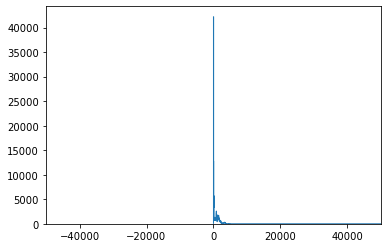

In [5]:
plt.hist(df['DEB_CRE_USD'],bins='auto', histtype='step')
plt.xlim(-50000,50000)

<AxesSubplot:>

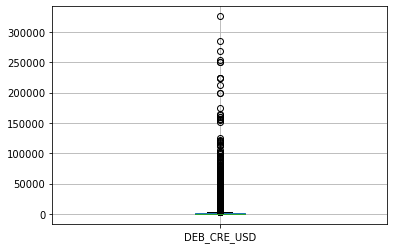

In [6]:
df.boxplot(column=['DEB_CRE_USD'])

,ACCNT_GRPV,AC_DOC_TYP,Compliance Bucket,GL_ACCOUNT,HCPClass,MATL_GROUP,POST_KEY,PROFIT_CTR,V.BIC_ZTERMPAY,V.BI_ACCNT_TGRPV,V.NAME,ZTCODE
ACCNT_GRPV,1.000000,0.707142,0.474177,0.690965,0.036770,0.000000,0.000000,0.657808,0.871634,1.000000,0.997532,0.755365
AC_DOC_TYP,0.707142,1.000000,0.343688,0.845532,0.226780,0.086137,0.121958,0.729995,0.501568,0.707142,0.870388,0.999935
Compliance Bucket,0.474177,0.343688,1.000000,0.999779,0.877231,0.150327,0.212878,0.483358,0.245134,0.474177,0.826005,0.165736
GL_ACCOUNT,0.690965,0.845532,0.999779,1.000000,0.923000,0.148849,0.211837,0.432262,0.408556,0.690965,0.675704,0.642187
HCPClass,0.036770,0.226780,0.877231,0.923000,1.000000,0.034197,0.025543,0.785177,0.549522,0.036770,0.997744,0.821459
MATL_GROUP,0.000000,0.086137,0.150327,0.148849,0.034197,1.000000,0.999996,0.714427,0.012054,0.000000,0.863421,0.085035
POST_KEY,0.000000,0.121958,0.212878,0.211837,0.025543,0.999996,1.000000,0.714421,0.020927,0.000000,0.863416,0.121113
PROFIT_CTR,0.657808,0.729995,0.483358,0.432262,0.785177,0.714427,0.714421,1.000000,0.432036,0.657808,0.467135,0.627587
V.BIC_ZTERMPAY,0.871634,0.501568,0.245134,0.408556,0.549522,0.012054,0.020927,0.432036,1.000000,0.871634,0.843922,0.532068
V.BI_ACCNT_TGRPV,1.000000,0.707142,0.474177,0.690965,0.036770,0.000000,0.000000,0.657808,0.871634,1.000000,0.997532,0.755365


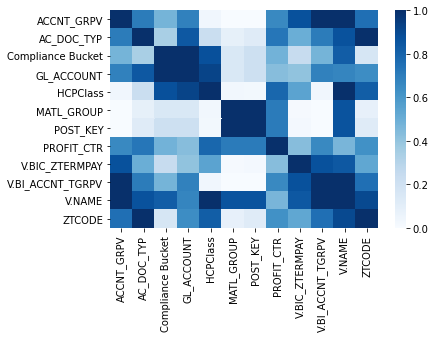

In [21]:
corMatrix = GenerateCramersVMatrix(df, ["HCPClass","PROFIT_CTR","AC_DOC_TYP","POST_KEY","GL_ACCOUNT","ZTCODE", "MATL_GROUP", "ACCNT_GRPV", "Compliance Bucket","V.BI_ACCNT_TGRPV", "V.BIC_ZTERMPAY", "V.NAME"])


sns.heatmap(corMatrix, cmap="Blues")
corMatrix

In [8]:
#Output features excludes non-features engineered fields and adds the dfscaled property to the object
modelVals.outputFeatures()

#fit_transform method minmaxscales the dfscaled dataset
modelVals.fit_transform()
dftrain = modelVals.dfscaled


dftrain.to_csv(pathBase + "\Datasets\csvoutput.csv")


dftrain

,ACCNT_GRPV_Z001,ACCNT_GRPV_Z003,ACCNT_GRPV_Z010,AC_DOC_TYP_AB,AC_DOC_TYP_CT,AC_DOC_TYP_KR,AC_DOC_TYP_RE,AC_DOC_TYP_ZP,"Compliance Bucket_Brand Reminders, Items of Medical Utility, & Cultural Courtesies",Compliance Bucket_Charitable Contributions,...,ZTCODE_FB08,ZTCODE_FB1K,ZTCODE_FB60,ZTCODE_FBD5,ZTCODE_FBVB,ZTCODE_MIRO,distanceFromMean,invoiceval,vendorCount,vendorMean
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000132,0.000303,0.009302,0.000230
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000701,0.000696,0.015992,0.000147
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000139,0.000012,0.015992,0.000147
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000127,0.000047,0.038194,0.000177
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000163,0.000018,0.038194,0.000177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115383,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000566,0.005851,0.007943,0.006340
115384,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000
115385,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000025,0.000055,1.000000,0.000088
115386,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000025,0.000055,1.000000,0.000088


In [9]:
featureList = list(dftrain[dftrain.columns.drop(list(dftrain.filter(regex='KeepAllFields')))].columns) #Filters fields NOT equal to given 

#HCPWord
modelsAnalyzer = Supervised_Analyzer(dftrain)


modelsAnalyzer = Supervised_Analyzer(dftrain)

modelObject = modelsAnalyzer.set_features(features=featureList).set_traintestsplit(target_field="HCPClass_labeled",test_split_size=.2)
#Once set_traintestsplit is called can now access arrays such as modelObject.x_train, x_test etc

#instance of gridsearch model is returned from models dict https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

SVM = modelObject.FitSVM()
#KN = modelObject.FitKNeighbors()


#to predict


Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [10]:
#SVM.Models['KNeighbors']['GSCV'].cv_results_]

#[SVM.Models['SVM']['GSCV'].best_score_,SVM.Models['KNeighbors']['GSCV'].best_score_]

SVM.Models['SVM']['GSCV'].cv_results_

{'mean_fit_time': array([5.92148447]),
 'std_fit_time': array([0.16671487]),
 'mean_score_time': array([0.19475818]),
 'std_score_time': array([0.02400756]),
 'param_C': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['linear'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'kernel': 'linear'}],
 'split0_test_score': array([0.99994583]),
 'split1_test_score': array([0.99994583]),
 'split2_test_score': array([0.99994583]),
 'split3_test_score': array([0.9998375]),
 'split4_test_score': array([0.99978334]),
 'mean_test_score': array([0.99989167]),
 'std_test_score': array([6.85143031e-05]),
 'rank_test_score': array([1])}

In [12]:
predictions = SVM.Models['SVM']['GSCV'].predict(modelObject.x_test)

testIndices = modelObject.indices_test

predictDF = pd.DataFrame({"index":testIndices, "predictedHCPClassification":predictions}).set_index("index")

predictDF = predictDF.merge(df,how='left', left_index=True, right_index=True)

predictDF.loc[predictDF.predictedHCPClassification == 1, "PredictedLabel"] = "Non-HCP"
predictDF.loc[predictDF.predictedHCPClassification == 0, "PredictedLabel"] = "HCP"

predictDF.loc[predictDF.predictedHCPClassification == predictDF.HCPClass, "PredictAccuracyBinary"] = True
predictDF.loc[predictDF.predictedHCPClassification != predictDF.HCPClass, "PredictAccuracyBinary"] = False


predictDF.to_csv(pathBase + "\Datasets\predictedoutput.csv")
#modelObject.x_train.shape


In [15]:
predictDF[['AC_DOC_NR','V.NAME', 'GL_ACCOUNT', 'AC_DOC_TYP','DEB_CRE_USD','PredictedLabel', 'HCPClass']]

,AC_DOC_NR,V.NAME,GL_ACCOUNT,AC_DOC_TYP,DEB_CRE_USD,PredictedLabel,HCPClass
index,,,,,,,
79885,1900108484,SCHNEIDER TRANSPORTATION MANAGEMENT,64900101,KR,2867.930000,Non-HCP,Non-HCP
63161,1900011024,DHL EXPRESS GERMANY GMBH,64900101,KR,24.484222,Non-HCP,Non-HCP
70955,1900000810,SCHNEIDER TRANSPORTATION MANAGEMENT,64900101,KR,3726.530000,Non-HCP,Non-HCP
48210,1900081275,AAA COOPER TRANSPORTATION,64900101,KR,683.130000,Non-HCP,Non-HCP
52353,1900172270,NAPA TRANSPORTATION INC,64900101,KR,855.050000,Non-HCP,Non-HCP
...,...,...,...,...,...,...,...
30499,1900150488,KLLM TRANSPORT,64900101,KR,1134.230000,Non-HCP,Non-HCP
87803,1900003467,DHL EXPRESS GERMANY GMBH,64900101,KR,18.845143,Non-HCP,Non-HCP
7880,1900033560,DR ANDREAS SCHNITZLER,61000115,KR,770.700000,HCP,HCP
